In [1]:
# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

""

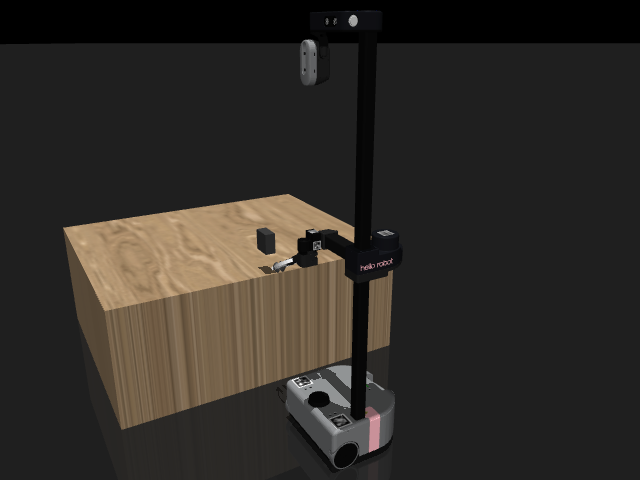

In [2]:
from pathlib import Path
import enum
from tqdm import tqdm

class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)

res = Resolution.SD
h, w = res.value

model_dir = Path("mujoco_menagerie/hello_robot_stretch") # You could also use google_robot
model_xml = model_dir / "scene.xml"

# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [4]:
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 4

duration = 10
fps = 30
nsteps = int(np.ceil(duration / model.opt.timestep))

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)


In [7]:
from math import *

class Robot:
    def __init__(self, model, data, vis, coll, camera):
        self.model = model
        self.data = data
        self.vis = vis
        self.coll = coll
        self.camera = camera
        self.x = 0
        self.y = 0
        self.tangent_angle = 0.0
        self.velocity = 0.0
        self.breadth = 0.0
        self.dt = 0.1
        self.treshold = 1
    
    def set_wheel_speeds(self, left_speed, right_speed):
        self.data.joint('joint_right_wheel').qvel = np.array([right_speed])
        self.data.joint('joint_left_wheel').qvel = np.array([left_speed])
    
    def distance_to_point(self, x_goal, y_goal, x, y):
        return sqrt((x_goal - x) ** 2 + (y_goal - y) ** 2)
    
    def arc_radius(x1, y1, x2, y2, tangent_angle):
        chord_length = sqrt((x2 - x1)**2 + (y2 - y1)**2)
        chord_angle = atan2(y2 - y1, x2 - x1)
        radius = chord_length / (2 * sin(pi - tangent_angle - abs(chord_angle)))
        next_angle = chord_angle * 2
        return radius, next_angle
    
    def update_position(self, left_speed, right_speed, dt):
        wheel_base = self.breadth
        v = (left_speed + right_speed) / 2.0
        omega = (right_speed - left_speed) / wheel_base
        self.x += v * cos(self.tangent_angle) * dt
        self.y += v * sin(self.tangent_angle) * dt
        self.tangent_angle += omega * dt
        # print(f'x, y: {self.x, self.y}, v: {v}')
    
    def control_robot_to_point(self, x_goal, y_goal):
        duration = 10
        fps = 30
        nsteps = int(np.ceil(duration / model.opt.timestep))
        x = self.x
        y = self.y
        
        # Set the desired control point.
        if model.nkey > 0:
            mujoco.mj_resetDataKeyframe(model, data, 0)
            ctrl0 = data.ctrl.copy()
        else:
            mujoco.mj_resetData(model, data)
            ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)

        frames = []
        
        for i in tqdm(range(nsteps)):
        # while self.distance_to_point(self, x_goal, y_goal, self.x, self.y) > self.threshold:
            distance = self.distance_to_point(self, x_goal, y_goal, self.x, self.y)    
            if distance > self.threshold:                            
                radius, next_angle = self.arc_radius(self.x, self.y, x_goal, y_goal, self.tangent_angle)
                chord_angle = atan2(y_goal - self.y, x_goal - self.x)
                angle_diff = chord_angle * 2
                # angle_diff = angle_to_goal - self.theta
                # omega = self.velocity / radius
                # omega = self.velocity / radius
                
                if angle_diff > pi:
                    angle_diff -= 2 * pi
                elif angle_diff < -pi:
                    angle_diff += 2 * pi
                
                if radius == 0:
                    v_left = self.velocity
                    v_right = self.velocity
                else:
                    omega = self.velocity / radius
                    v_left = self.velocity * (radius + self.breadth/2) / radius
                    v_right = self.velocity * (radius - self.breadth/2) / radius
                # print(distance, radius, v_left, v_right)
                # v_left = v - omega * angle_diff
                # v_right = v + omega * angle_diff
                
                # self.set_wheel_speeds(self, v_left, v_right)
                self.set_wheel_speeds(self, v_left, v_right)
                self.update_position(self, v_left, v_right, self.dt)

                '''  ### #### ###  '''
                # for i in tqdm(range(nsteps)):
                
                # print(v_left, v_right)
                # data.joint('joint_right_wheel').qvel = np.array([rv])
                # data.joint('joint_left_wheel').qvel = np.array([rl])
            else:
                self.set_wheel_speeds(self, 0, 0)

            mujoco.mj_step(model, data)
            if len(frames) < data.time * fps:
                renderer.update_scene(data, self.camera, scene_option=self.vis)
                vispix = renderer.render().copy().astype(np.float32)
                frame = vispix.astype(np.uint8)
                frames.append(frame)
            
        media.show_video(frames, fps=fps, loop=False)

        self.set_wheel_speeds(self, 0, 0)
        print("Reached the goal and stopped.")

robot = Robot
robot.__init__(robot, model, data, vis, coll, camera)
robot.velocity = 1
robot.breadth = 0.2
x_goal, y_goal = 0, 2
robot.x, robot.y = 0, 0 
robot.threshold = 1
robot.tangent_angle = 0
robot.control_robot_to_point(robot, x_goal, y_goal)

100%|██████████| 5000/5000 [00:04<00:00, 1072.35it/s]


Reached the goal and stopped.
